In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cv
import time
import gurobipy as gp
from gurobipy import GRB
import scipy

# Independent Telegraphs with regulation

We consider a stochastic reaction network where 2 telegraph models act independently, each with a gene that switches between on and off and produces transcripts, except that the 2 transcripts regulate each other:

$ G_{1, off} \underset{k_{1, off}}{\stackrel{k_{1, on}}{\rightleftharpoons}} G_{1, on}  \quad\quad G_{2, off} \underset{k_{2, off}}{\stackrel{k_{2, on}}{\rightleftharpoons}} G_{2, on}$

$ G_{1, on} \stackrel{k_{1, tx}}\longrightarrow G_{1, on} + X_{1} \quad\quad G_{2, on} \stackrel{k_{2, tx}}\longrightarrow G_{2, on} + X_{2} $

$ X_{1} \stackrel{k_{1, deg}}\longrightarrow \varnothing \quad\quad X_{2} \stackrel{k_{2, deg}}\longrightarrow \varnothing $

$ X_{1} + X_{2} \stackrel{k_{reg}}\longrightarrow \varnothing $

Again we observe only the number of molcules of the transcripts $X_{1}$ and $X_{2}$ but not the state of the genes $G_{1}$ and $G_{2}$.

The state of the system can be written as $(x_{1}, x_{2}, g_{1}, g_{2}) \in \mathbb{N}^{2} \times \{0, 1\}^{2}$ where $0$ denotes the off state and $1$ the on state of each gene.

## Simulation

Without an explicit stationary distribution we instead use gillespie / SSA to simulate sample paths of the reaction network. After a sufficient time (burn in) we can take the state of the system as a sample from the stationary distribution.

In [7]:
rng = np.random.default_rng(2939)

In [8]:
def simulation(params, n, tmax, ts, plot=False, initial_state=(0, 0, 1, 1)):
    '''
    Simulate a sample path of the telegraph-regulation model
    Sample n values at intervals of ts after a burn-in time of tmax

    params: dict of reaction rate constants
    n: number of samples
    tmax: burn in time
    ts: time between samples
    '''

    # initialise time and state
    t = 0
    path = [initial_state]
    jump_times = [0]

    # simulate for burn-in time and time between n samples
    while t < tmax + (n - 1) * ts:

        # current state
        x1, x2, g1, g2 = path[-1][0], path[-1][1], path[-1][2], path[-1][3]

        # transition rates
        q_on_1 = (1 - g1) * params['k_on_1']
        q_on_2 = (1 - g2) * params['k_on_2']
        q_off_1 = g1 * params['k_off_1']
        q_off_2 = g2 * params['k_off_2']
        q_tx_1 = g1 * params['k_tx_1']
        q_tx_2 = g2 * params['k_tx_2']
        q_deg_1 = x1 * params['k_deg_1']
        q_deg_2 = x2 * params['k_deg_2']
        q_reg = x1 * x2 * params['k_reg']
        q_hold = q_on_1 + q_on_2 + q_off_1 + q_off_2 + q_tx_1 + q_tx_2 + \
            q_deg_1 + q_deg_2 + q_reg

        # holding time in current state
        t_hold = -np.log(rng.uniform()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        outcome = [1, 2, 3, 4, 5, 6, 7, 8, 9]
        prob = [
            q_on_1 / q_hold,
            q_on_2 / q_hold,
            q_off_1 / q_hold,
            q_off_2 / q_hold,
            q_tx_1 / q_hold,
            q_tx_2 / q_hold,
            q_deg_1 / q_hold,
            q_deg_2 / q_hold,
            q_reg / q_hold
        ]
        jump = rng.choice(outcome, p=prob)
        match jump:
            case 1:
                path.append((x1, x2, g1 + 1, g2))
            case 2:
                path.append((x1, x2, g1, g2 + 1))
            case 3:
                path.append((x1, x2, g1 - 1, g2))
            case 4:
                path.append((x1, x2, g1, g2 - 1))
            case 5:
                path.append((x1 + 1, x2, g1, g2))
            case 6:
                path.append((x1, x2 + 1, g1, g2))
            case 7:
                path.append((x1 - 1, x2, g1, g2))
            case 8:
                path.append((x1, x2 - 1, g1, g2))
            case 9:
                path.append((x1 - 1, x2 - 1, g1, g2))

    # take the transcript states
    x1_path = [state[0] for state in path]
    x2_path = [state[1] for state in path]

    # create step function of sample path from jump times and jump values
    x1_path_function = scipy.interpolate.interp1d(jump_times, x1_path, kind='previous')
    x2_path_function = scipy.interpolate.interp1d(jump_times, x2_path, kind='previous')

    # take values at sampling times as samples from stationary dist
    sample_times = [tmax + i * ts for i in range(n)]
    x1_samples = x1_path_function(sample_times)
    x2_samples = x2_path_function(sample_times)
    samples = [(int(x1_samples[i]), int(x2_samples[i])) for i in range(n)]

    # plot sample paths
    if plot:
        x = np.linspace(0, tmax + (n - 1) * ts, 10000)
        plt.plot(x, x1_path_function(x), label="X1 sample path", color="blue")
        plt.plot(x, x2_path_function(x), label="X2 sample path", color="purple")
        #plt.axvline(tmax, label="Burn-in time", color="orange")
        plt.xlabel("Time")
        plt.ylabel("# molcules")
        plt.legend()
        plt.show()

    return samples

### Example

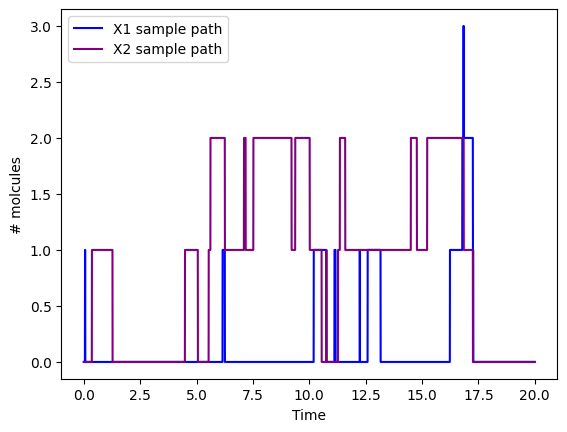

In [9]:
params = {
    'k_on_1': 1,
    'k_on_2': 1,
    'k_off_1': 1,
    'k_off_2': 1,
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 1
}
samples = simulation(params, 2, 10, 10, plot=True)

## Bootstrap

Given samples from the staitonary distribution of the reaction network we compute confidence intervals on the probabilities of the distribution using the bootstrap. By resampling and computing the empirical distribution on each sample we can produce 95% confidence intervals.

NOTE: previous efficient bootstrap no longer works, as cannot use bincount on pairs of integers

In [10]:
def bootstrap(params, n, B, tmax=100, ts=10, plot=False, printing=False, initial_state=(0, 0, 1, 1)):
    '''
    Compute bootstrap confidence intervals on the stationary distribution of system
    Simulate sample path and compute empirical distribution over each bootstrap sample

    params: dict of reaction rate constants
    n: number of samples from the stationary distribution
    B: number of bootstrap resamples
    tmax: burn-in time for sampling
    ts: time between samples
    plot: toggle plotting CI's
    printing: toggle printing CI's
    initial_state: starting point of sampling
    '''

    # n samples from stationary distribution
    samples = simulation(params, n, tmax, ts, plot=False, initial_state=initial_state)

    # separate x1 and x2 values (always considered paired, but for computational reasons)
    x1_samples = [sample[0] for sample in samples]
    x2_samples = [sample[1] for sample in samples]

    # maximum values found (+ 1)
    M = np.max(x1_samples) + 1
    N = np.max(x2_samples) + 1

    # array to count occurances per state per bootstrap sample
    counts = np.zeros((B, M, N))
    x1_counts = np.zeros((B, M))
    x2_counts = np.zeros((B, N))

    # B bootstrap samples of size n in B x n array
    boot = rng.choice(samples, size=(B, n))

    # loop over each sample (row) and add to counts
    for b in range(B):
        for i in range(n):
            x1, x2 = boot[b, i]
            counts[b, x1, x2] += 1
            x1_counts[b, x1] += 1
            x2_counts[b, x2] += 1

    # normalize counts to probabilities
    counts /= n
    x1_counts /= n
    x2_counts /= n

    # take 2.5%, 97.5% percentiles for each p(x1, x2)
    # gives 2 x M x N array of lower and upper bounds (axis 0) for each p(x1, x2)
    bounds = np.quantile(counts, [0.025, 0.975], axis=0)
    x1_bounds = np.quantile(x1_counts, [0.025, 0.975], axis=0)
    x2_bounds = np.quantile(x2_counts, [0.025, 0.975], axis=0)

    # plotting
    if plot:
        fig, axs = plt.subplots(M, N, figsize=(10, 10))
        fig.tight_layout()
        for x1 in range(M):
            for x2 in range(N):
                axs[x1, x2].hist(counts[:, x1, x2])
                axs[x1, x2].set_title(f"p({x1}, {x2})")
                axs[x1, x2].axvline(bounds[0, x1, x2], color="red")
                axs[x1, x2].axvline(bounds[1, x1, x2], color="red")

        plt.suptitle("X1 X2 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, M, figsize=(10, 3))
        fig.tight_layout()
        for x1 in range(M):
            axs[x1].hist(x1_counts[:, x1])
            axs[x1].set_title(f"p({x1})")
            axs[x1].axvline(x1_bounds[0, x1], color="red")
            axs[x1].axvline(x1_bounds[1, x1], color="red")

        plt.suptitle("X1 Confidence Intervals")
        plt.show()

        fig, axs = plt.subplots(1, N, figsize=(10, 3))
        fig.tight_layout()
        for x2 in range(N):
            axs[x2].hist(x2_counts[:, x2])
            axs[x2].set_title(f"p({x2})")
            axs[x2].axvline(x2_bounds[0, x2], color="red")
            axs[x2].axvline(x2_bounds[1, x2], color="red")

        plt.suptitle("X2 Confidence Intervals")
        plt.show()

    return {'joint': bounds, 'x1': x1_bounds, 'x2': x2_bounds}

### Example

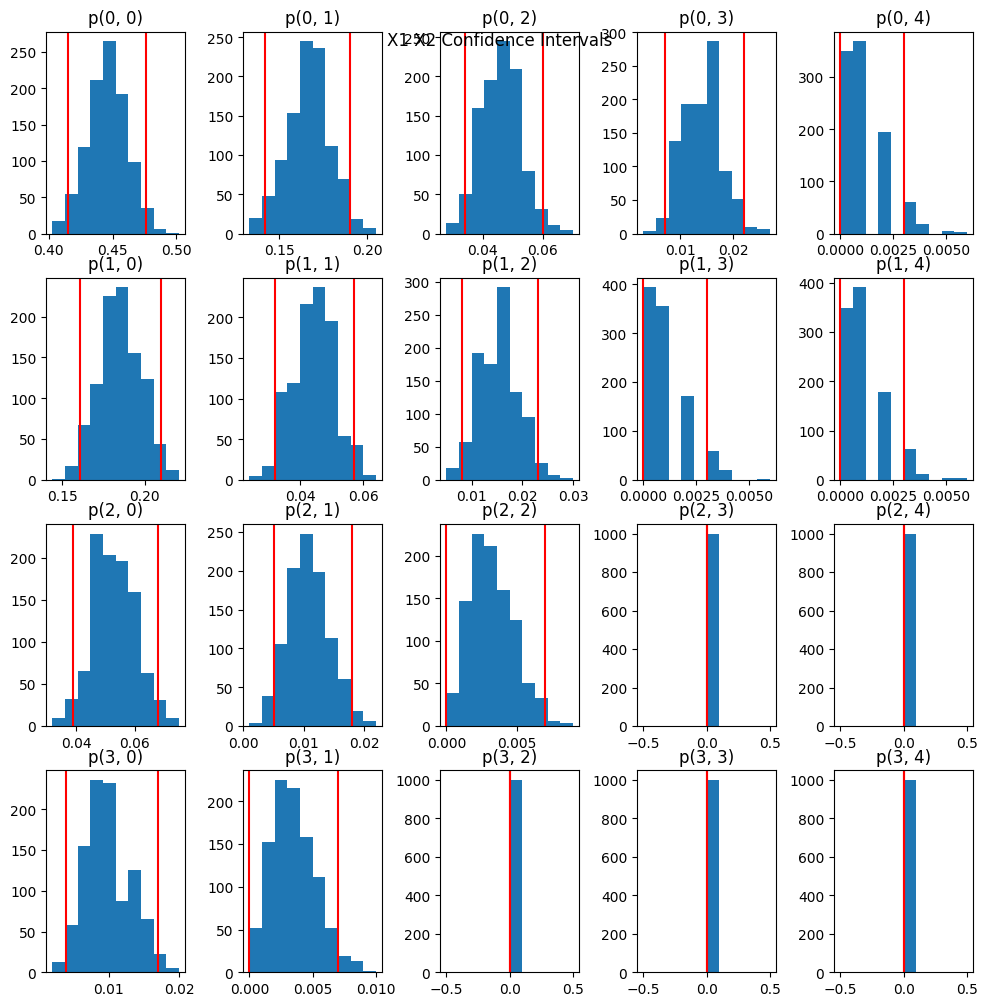

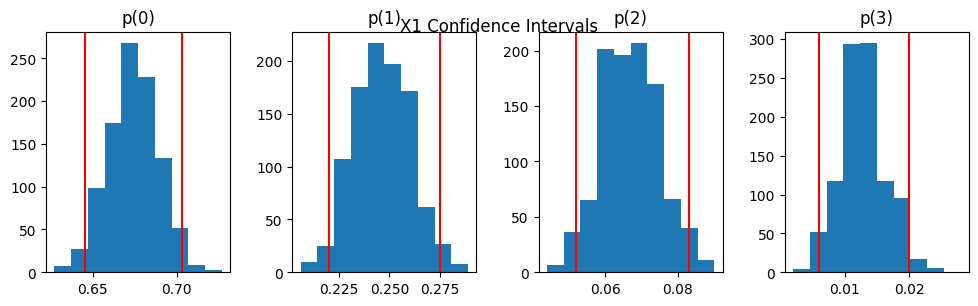

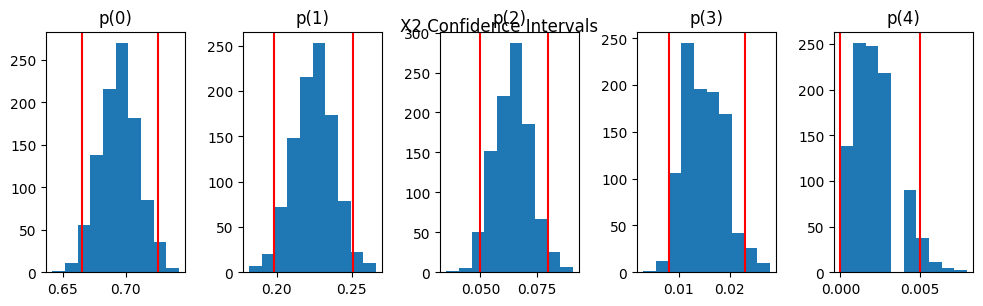

In [11]:
bounds = bootstrap(params, 1000, 1000, plot=True)

## Optimization

In [51]:
def optimization(params, bounds, N=None, M=None, K=10, silent=True, print_solution=True, test_feasible=False):
    '''
    Non-linear optimization to produce bounds on parameters of interest

    params: variable or fixed reaction rate constants
    bounds: 2 x M x N array of confidence interval bounds on stat. dist. of system
    silent: toggle printing of optimization status
    '''

    # create model
    md = gp.Model('telegraph-regulation')

    # set options
    if silent:
        md.Params.LogToConsole = 0

    # size
    if not M:
        M = bounds.shape[1]
    if not N:
        N = bounds.shape[2]

    # variables

    # stationary distribution
    p = md.addMVar(shape=(M, N, 2, 2), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)

    # reaction rate constants
    rate_names = ['k_on_1', 'k_on_2', 'k_off_1', 'k_off_2', 'k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg']
    rates = md.addVars(rate_names, vtype=GRB.CONTINUOUS, lb=0, ub=K, name=rate_names)

    # constraints

    # set fixed values
    for name, value in params.items():
        if value == "v":
            pass
        else:
            md.addConstr(rates[name] == value)

    # (marginal) stationary distribution bounds
    for x1 in range(M):
        for x2 in range(N):
            md.addConstr(bounds['joint'][0, x1, x2] <= p[x1, x2, 0, 0] + p[x1, x2, 1, 0] + p[x1, x2, 0, 1] + p[x1, x2, 1, 1], name=f"Marginal lb {x1}, {x2}")
            md.addConstr(bounds['joint'][1, x1, x2] >= p[x1, x2, 0, 0] + p[x1, x2, 1, 0] + p[x1, x2, 0, 1] + p[x1, x2, 1, 1], name=f"Marginal ub {x1}, {x2}")

    # additional frechet bounds
    for x1 in range(M):
        for x2 in range(N):
            for g1 in [0, 1]:
                for g2 in [0, 1]:
                    # expressions for p(g1) and p(g2)
                    
                    # add new variables
                    p_g1 = md.addVar(vtype=GRB.CONTINUOUS, name='p_g1')
                    p_g2 = md.addVar(vtype=GRB.CONTINUOUS, name='p_g2')

                    # set equal to values
                    if g1 == 1:
                        md.addConstr(p_g1 * (rates['k_on_1'] + rates['k_off_1']) == rates['k_on_1'])
                    else:
                        md.addConstr(p_g1 * (rates['k_on_1'] + rates['k_off_1']) == rates['k_off_1'])
                    if g2 == 1:
                        md.addConstr(p_g2 * (rates['k_on_2'] + rates['k_off_2']) == rates['k_on_2'])
                    else:
                        md.addConstr(p_g2 * (rates['k_on_2'] + rates['k_off_2']) == rates['k_off_2'])

                    # use in bounds
                    md.addConstr(p[x1, x2, g1, g2] >= bounds['x1'][0, x1] + bounds['x2'][0, x2] + p_g1 + p_g2 - 3, name="Frechet all lb")
                    md.addConstr(p[x1, x2, g1, g2] >= bounds['joint'][0, x1, x2] + p_g1 + p_g2 - 2, name="Frechet joint lb")
                    md.addConstr(p[x1, x2, g1, g2] <= bounds['joint'][1, x1, x2])
                    md.addConstr(p[x1, x2, g1, g2] <= bounds['x1'][1, x1])
                    md.addConstr(p[x1, x2, g1, g2] <= bounds['x2'][1, x2])
                    md.addConstr(p[x1, x2, g1, g2] <= p_g1)
                    md.addConstr(p[x1, x2, g1, g2] <= p_g2)

    # distribution
    md.addConstr(p.sum() <= 1, name="Distribution")
    
    # stationary Qp=0 equations for all relevant variables
    for x1 in range(M - 1):
        for x2 in range(N - 1):
            for g1 in [0, 1]:
                for g2 in [0, 1]:
                    if x1 == 0:
                        x1_zero = 0
                    else:
                        x1_zero = 1
                    if x2 == 0:
                        x2_zero = 0
                    else:
                        x2_zero = 1

                    md.addConstr( 
                        rates['k_on_1'] * g1 * p[x1, x2, 0, g2] + \
                        rates['k_on_2'] * g2 * p[x1, x2, g1, 0] + \
                        rates['k_off_1'] * (1 - g1) * p[x1, x2, 1, g2] + \
                        rates['k_off_2'] * (1 - g2) * p[x1, x2, g1, 1] + \
                        # need to remove this when x1 or x2 = 0, since not in equation (index = -1 crrently taking end of array)
                        # so multiply by toggle
                        rates['k_tx_1'] * g1 * x1_zero * p[x1 - 1, x2, g1, g2] + \
                        rates['k_tx_2'] * g2 * x2_zero * p[x1, x2 - 1, g1, g2] + \
                        rates['k_deg_1'] * (x1 + 1) * p[x1 + 1, x2, g1, g2] + \
                        rates['k_deg_2'] * (x2 + 1) * p[x1, x2 + 1, g1, g2] + \
                        rates['k_reg'] * (x1 + 1) * (x2 + 1) * p[x1 + 1, x2 + 1, g1, g2] - \
                        (rates['k_on_1'] * (1 - g1) + rates['k_on_2'] * (1 - g2) + \
                         rates['k_off_1'] * g1 + rates['k_off_2'] * g2 + \
                         rates['k_tx_1'] * g1 + rates['k_tx_2'] * g2 + \
                         rates['k_deg_1'] * x1 + rates['k_deg_2'] * x2 + \
                         rates['k_reg'] * x1 * x2) * p[x1, x2, g1, g2] == 0,
                        name=f"Equation {x1}, {x2}, {g1}, {g2}"
                    )

    # solution dict
    solution = {}

    # optimize
    for name, value in params.items():

        # variable
        if value == "v":

            # minimize
            md.setObjective(rates[name], GRB.MINIMIZE)
            try:
                md.optimize()
                min_val = md.ObjVal
            except:
                min_val = None

            # maximize
            md.setObjective(rates[name], GRB.MAXIMIZE)
            try:
                md.optimize()
                max_val = md.ObjVal
            except:
                max_val = None

            # store
            solution[name] = [min_val, max_val]
    
        # constant
        else:
            solution[name] = value

    md.Params.DualReductions = 0

    if test_feasible:
        # if testing feasibility simply optimize 1 to check
        md.setObjective(1, GRB.MINIMIZE)

        # set parameter (prevents 'infeasible or unbounded' ambiguity)
        md.Params.DualReductions = 0
        try:
            md.optimize()
            status_code = md.status
        except:
            status_code = md.status

        # decode status
        status_codes = {1: 'LOADED',
                        2: 'OPTIMAL',
                        3: 'INFEASIBLE',
                        4: 'INF_OR_UNBD',
                        5: 'UNBOUNDED',
                        6: 'CUTOFF',
                        7: 'ITERATION_LIMIT',
                        8: 'NODE_LIMIT',
                        9: 'TIME_LIMIT',
                        10: 'SOLUTION_LIMIT',
                        11: 'INTERRUPTED',
                        12: 'NUMERIC',
                        13: 'SUBOPTIMAL',
                        14: 'INPROGRESS',
                        15: 'USER_OBJ_LIMIT'}

        # store result
        solution['feasible'] = status_codes[status_code]

    # print
    if print_solution:
        for key, val in solution.items():
            if key == 'feasible':
                print(f"Model is {val}")
            elif type(val) == list:
                print(f"{key} in ({val[0]}, {val[1]})")
            else:
                print(f"{key} = {val}")

    return solution
        

### Example

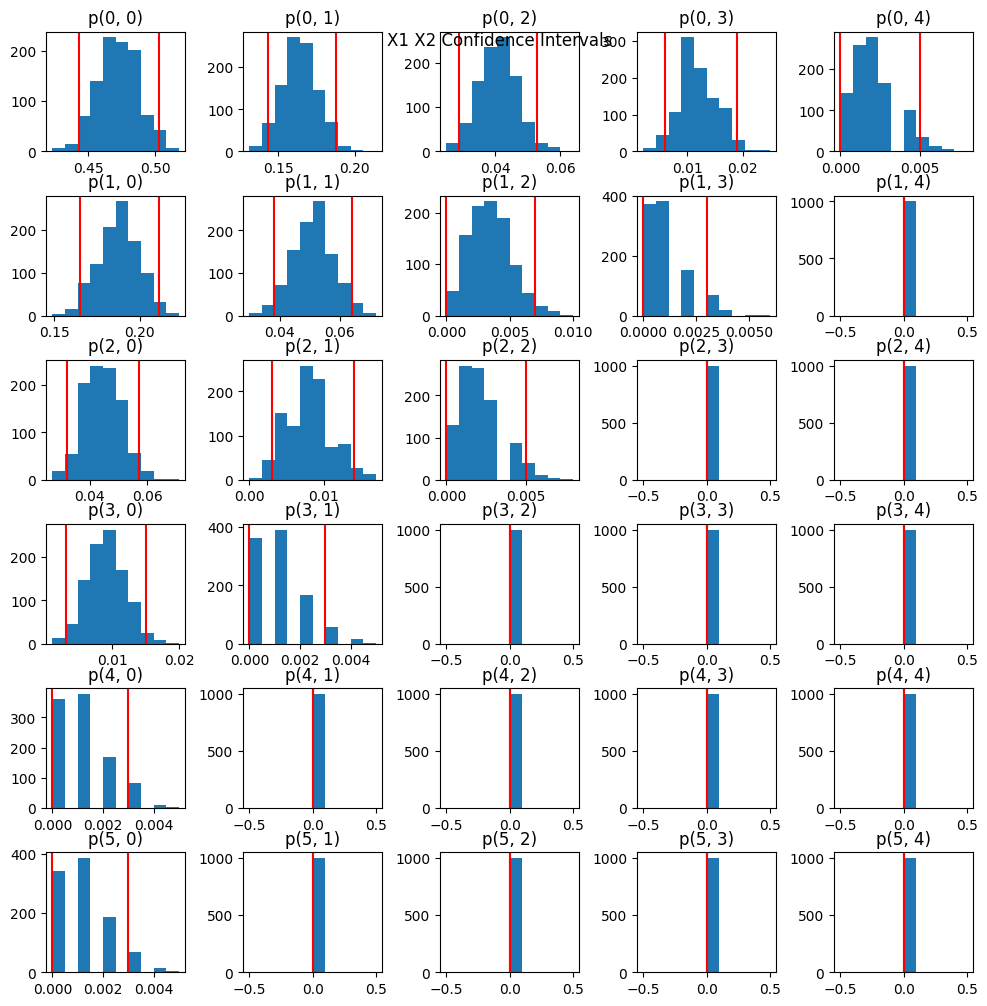

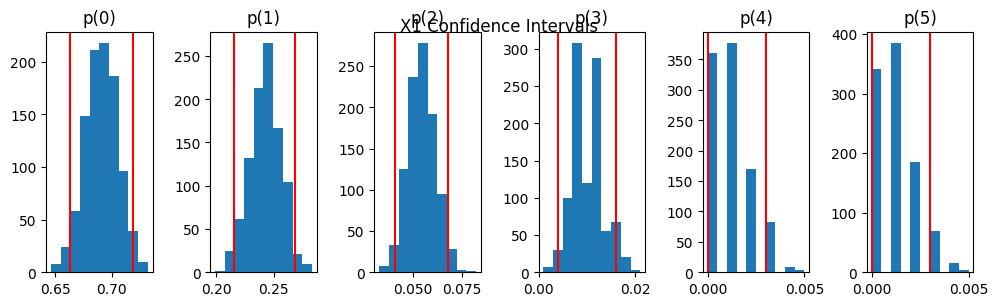

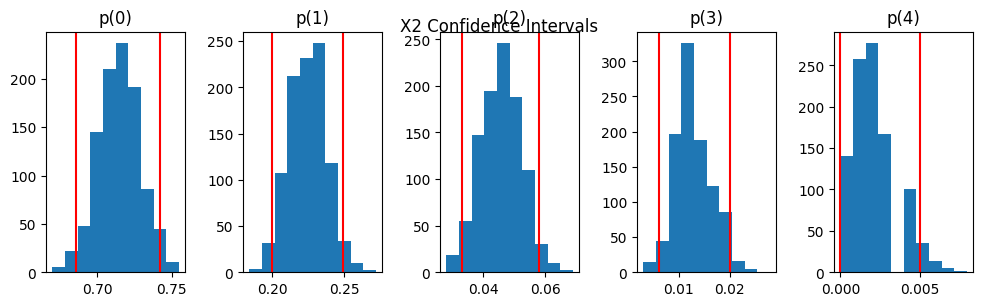

In [18]:
# set parameter values for simulation
params = {
    'k_on_1': 1,
    'k_on_2': 1,
    'k_off_1': 1,
    'k_off_2': 1,
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 1
}

# simulate and bootstrap to produce CI bounds on stat. dist.
bounds = bootstrap(params, 1000, 1000, plot=True)

In [19]:
bounds['joint'].shape

(2, 6, 5)

In [20]:
# choose variable / fixed parameters for optimization
params_optim = {
    'k_on_1': 1,
    'k_on_2': 1,
    'k_off_1': 1,
    'k_off_2': 1,
    'k_tx_1': "v",
    'k_tx_2': "v",
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 1
}

In [21]:
# optimize
solution = optimization(params_optim, bounds, M=3, N=3, silent=True)

k_on_1 = 1
k_on_2 = 1
k_off_1 = 1
k_off_2 = 1
k_tx_1 in (0.35659207413028304, 2.4931467471240976)
k_tx_2 in (0.28603548242316024, 2.2685707507844084)
k_deg_1 = 1
k_deg_2 = 1
k_reg = 1


# Testing for interaction

Consider two transcripts $X_{1}$ and $X_{2}$ produced by genes. If there is no interaction we expect they can be modelled by two independent telegraph models. However, if there is interaction e.g. regulation $X_{1} + X_{2} \stackrel{k_{reg}}\longrightarrow \varnothing $ we expect that the model without this reaction, i.e. independent telegraphs, will not hold.

Fixing $k_{reg} = 0$ in the optimization and using computed bounds, an infeasible result suggests (to the 95% confidence level of the data) that interaction is present since with no interaction reaction the model does not fit the data, although a feasible solution does not confirm that there is no interaction.

Additionally, if optimizing over $k_{reg}$ as a variable produces solution bounds that do not contain 0 then this suggests (95% confidence) the presence of interaction.

## Example

Simulating data from a reaction with a large regulation parameter e.g. $k_{reg} = 10$ we compute confidence intervals from the data and optimize, fixing $k_{reg} = 0$ or leaving it variable:

In [33]:
# parameter values for simulation: large regulation
params_simul = {
    'k_on_1': 1,
    'k_on_2': 1,
    'k_off_1': 1,
    'k_off_2': 1,
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 10
}
# fix regulation parameter to 0
params_optim_zero = {
    'k_on_1': 1,
    'k_on_2': 1,
    'k_off_1': 1,
    'k_off_2': 1,
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

# optimize over regulation parameter
params_optim_var = {
    'k_on_1': 1,
    'k_on_2': 1,
    'k_off_1': 1,
    'k_off_2': 1,
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': "v"
}

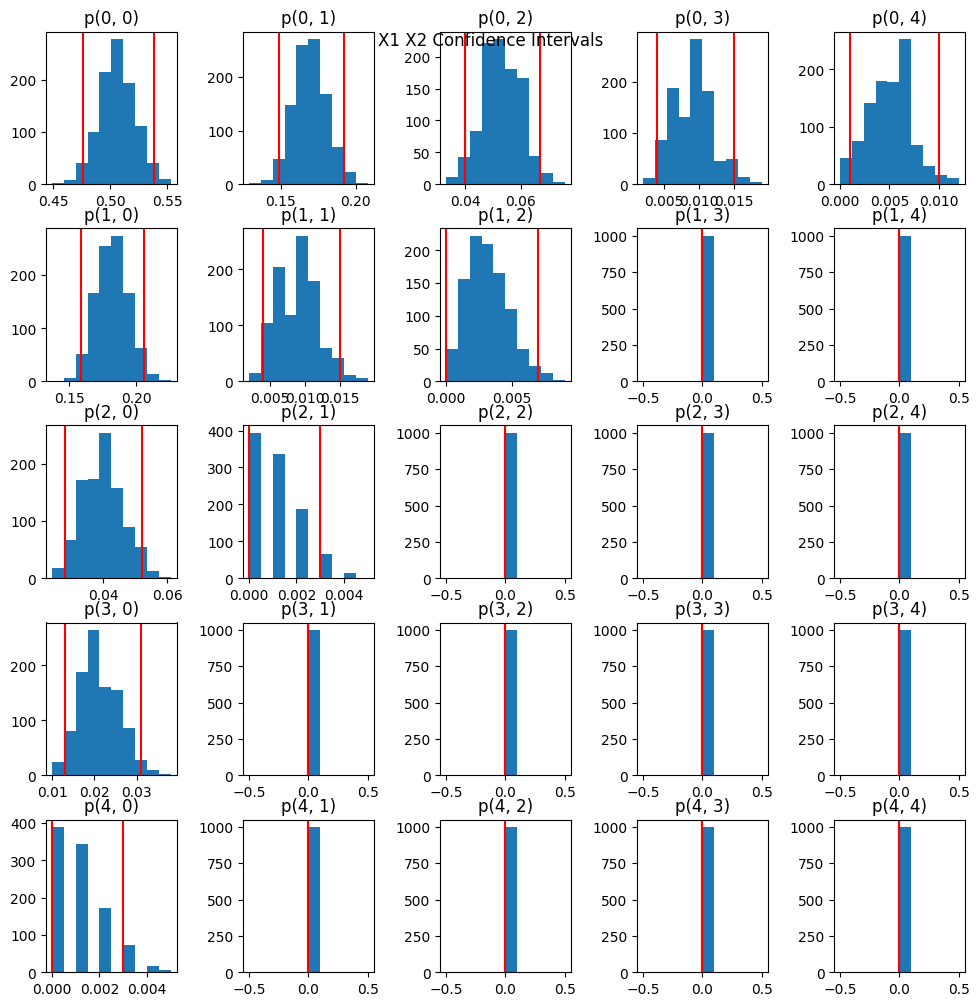

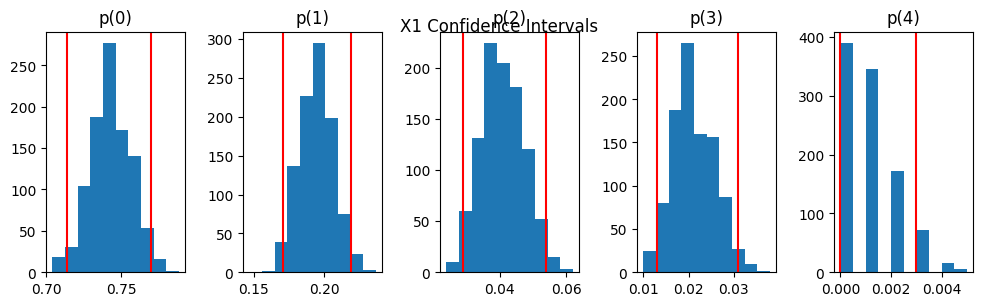

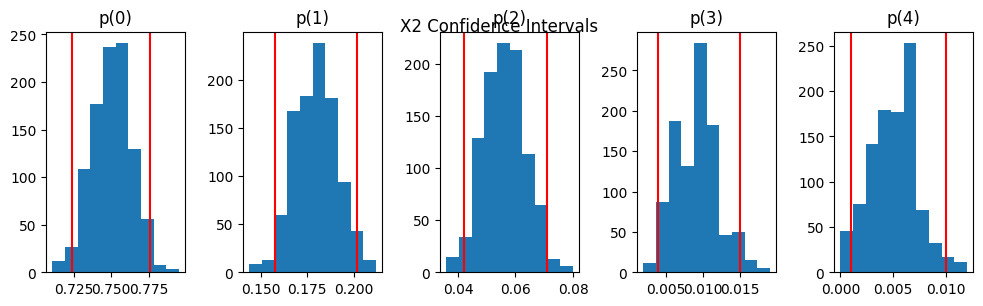

In [29]:
# simulate and bootstrap to produce CI bounds on stat. dist.
bounds_test = bootstrap(params_simul, 1000, 1000, plot=True)

In [52]:
# fix k_reg = 0, use data with high regulation
solution_test = optimization(params_optim_zero, bounds_test, M=3, N=3, silent=True, test_feasible=True)

k_on_1 = 1
k_on_2 = 1
k_off_1 = 1
k_off_2 = 1
k_tx_1 = 1
k_tx_2 = 1
k_deg_1 = 1
k_deg_2 = 1
k_reg = 0
Model is INFEASIBLE


With all parameters fixed to their true values, except for $k_{reg}$ which is fixed to 0 instead of the true (high) value used to simulate the data, we expect the optimization to be infeasible and see so above, $\textbf{suggesting}$ there is interaction in the model.

In [54]:
# leave k_reg variable, use data with high regulation
solution_test = optimization(params_optim_var, bounds_test, M=3, N=3, K=20, silent=True)

k_on_1 = 1
k_on_2 = 1
k_off_1 = 1
k_off_2 = 1
k_tx_1 = 1
k_tx_2 = 1
k_deg_1 = 1
k_deg_2 = 1
k_reg in (3.9399351484939964, 20.0)


With all parameter fixed to their true value, except $k_{reg}$ which is a variable to be optimized, we see that the resulting bounds exclude 0 (and contain the true value of 10) which $\textbf{suggests}$ there is interaction in the model.